# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [1]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non

### On reprend les éléments du notebook de l'étape 2

In [2]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape2_clean.csv")

# Partie 4 - Améliorez l'approche de classification

### Recommandation 1 - Avant toute implémentation en code, mettre sur le papier votre approche de modélisation. C’est-à-dire : avec quelle méthodologie je découpe mon jeu de données en apprentissage et test, de quelles métriques d’évaluation je vais avoir besoin etc.

* L'objectif va être de gérer le déséquilibre de notre jeu de données. Nous devons également mieux le stratifier et déterminer le bon seuil de classification avec une courbe PR. Nous sommes dans une situation de déséquilibre alors la courbe ROC n'est pas adaptée.

* D'après les résultats obtenus par l'étape 3, il semble important de mettre l'accent sur l'amélioration de la métrique Recall qui n'est pas bonne pour chacun des modèles testés.
* D'autant plus dans un sens métier, il est plus judicieux de bien trouver les Faux Négatifs, c'est à dire les salariés qui ont démissionné mais qui sont considérés comme encore dans l'entreprise.
* La métrique Recall / la matrice de confusion / la balanced_accuracy  vont nous permettre de mieux comprendre les résultats.
* La métrique Accuracy n'est pas utilisable pour le moment car le déséquilibre fausse la métrique, elle va trouver facilement le Non qui domine notre jeu de données à hauteur de 84%.

Dans un premier temps nous allons faire une validation croisée pour analyser la moyenne et l'écart-type de nos différents modèles et en sélectionner le plus pertinent.
Dans un deuxième temps nous irons plus loin dans l'analyse du meilleur modèle, nous regarderons sa courbe PR, son histogramme des probabilités et nous déterminerons le seuil optimal pour gérer le déséquilibre.

Réalisation de différents tests sur 3 modèles non linéaires (il est demandé dans l'énoncé d'utiliser un modèle non linéaire):
* Choix du modèle non-linéaire RandomForest
* Choix du modèle non-linéaire XGBoost
* Choix du modèle non-linéaire CatBoost

## Création d'une fonction pour appliquer nos modèles

### Application des recommandations suivantes :
* Capitaliser sur les fonctions existantes dans sklearn et privilégier leur utilisation (notamment pour la stratification), à moins que votre méthodologie soit très personnalisée.

* Pendant votre validation croisée, stocker les métriques de chaque itération de Fold dans une liste. Il est très utile de calculer une moyenne ainsi qu’un écart-type sur ces listes. Cela vous donnera une bonne indication sur l’existence ou non d’un overfit, ainsi que la capacité d’un modèle à généraliser son apprentissage à de nouvelles données.

* Utiliser la courbe précision rappel pour déterminer le seuil optimal que doit utiliser votre modèle pour classifier vos observations.

* Si vous êtes déjà à l’aise au niveau du code pour utiliser les différents concepts et librairies, vous pouvez vous intéresser aux fonctionnalités pipelines de sklearn pour mieux organiser vos modélisations.

#### Nous reprenons notre fonction pour récupérer X/y et nos colonnes encodées ou non.

In [3]:
X, y = prepare_xy(donnees_modelisation)
features_a_scaler, features_encodees = scaler_ou_non()

### Séparation de notre jeu - Validation croisée - Métriques sur CV

In [4]:
# Création d'une fonction et pour figer nos conditions
def modelisation(model, donnees_modelisation, target_col='a_quitte_l_entreprise', test_size=0.2, random_state=42):
# Séparation de X et y
    X, y

# Test en jeu d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state, stratify=y)
    
 # Demande d'une transformation des colonnes non encodées en scaling et création d'un pipeline
    preprocessor = ColumnTransformer(
        transformers = [
            ('num',StandardScaler(),features_a_scaler),
            ('cat','passthrough',features_encodees)
        ])
    pipeline = Pipeline(steps=[
        ('preproccesor', preprocessor),
        ('model', model)
    ])
# Choix des indicateurs de performance et création de la validation croisée    
    scoring = ['precision','recall','f1','average_precision','balanced_accuracy'] # average_precision = PR AUC
    cv_results = cross_validate(
        pipeline,
        X_train, y_train, # validation croisée que sur l'entraînement
        cv=StratifiedKFold(n_splits=3), #KFold va renvoyer des plis stratifiés
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("=== Résultats CV (train vs val) ===")

# Boucle pour calcul de nos indicateurs
    for metric in scoring:
        tr = cv_results[f"train_{metric}"]
        te = cv_results[f"test_{metric}"]
        print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

    return model

* La validation croisée K-Fold stratifiée est une technique utilisée pour évaluer un modèle. Il est particulièrement utile pour les problèmes de classification dans lesquels les étiquettes de classe ne sont pas uniformément réparties, c'est-à-dire que les données sont déséquilibrées. C'est une version améliorée de K-Fold Cross Validation. La principale différence est qu'il utilise une stratification qui permet de maintenir la distribution originale de chaque classe à travers chaque pli. Ici nous utilisons 3 splits

#### Choix de nos modèles et ajustements avec quelques hyperparamètres
* Ajout notamment pour RandomForest et XGBoost de class weight afin de gérer un peu mieux notre jeu déséquilibré.

In [5]:
modeles = {
    "Random Forest": RandomForestClassifier(
        random_state=42,
        n_estimators=300, # nombre d’arbres dans la forêt
        max_depth=3, # profondeur maximale de chaque arbre
        min_samples_split=10, # nombre minimum d’échantillons pour diviser un noeud
        class_weight={0: 0.60, 1: 3.12}  # pondération pour équilibrer classes majoritaire/minoritaire
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, #nombre d’arbres boostés
        max_depth=2, #profondeur max des arbres
        learning_rate=0.05, #taille des pas de gradient
        scale_pos_weight=5.25,  # ajuste l’importance de la classe minoritaire (utile si dataset déséquilibré)
        subsample=0.8, # proportion d’échantillons utilisés par arbre (régularisation)
        colsample_bytree=0.8, # proportion de variables utilisées par arbre (régularisation).
        random_state=42,
        eval_metric="logloss" # métrique d’évaluation interne
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.03, # vitesse d’apprentissage
        class_weights=[1, 5], # pondération des classes
        random_state=42,
        verbose=0
    )
}

# Boucle pour exécuter les modèles
for nom, clf in modeles.items():
    print("\n" + "="*40)
    print(f"Modèle : {nom}")
    print("="*40)
    modelisation(clf, donnees_modelisation)


Modèle : Random Forest
=== Résultats CV (train vs val) ===
precision         : train 0.472 ± 0.028 vs val 0.403 ± 0.078
recall            : train 0.710 ± 0.038 vs val 0.558 ± 0.056
f1                : train 0.567 ± 0.028 vs val 0.464 ± 0.064
average_precision : train 0.660 ± 0.041 vs val 0.515 ± 0.050
balanced_accuracy : train 0.778 ± 0.019 vs val 0.694 ± 0.039

Modèle : XGBoost
=== Résultats CV (train vs val) ===
precision         : train 0.588 ± 0.018 vs val 0.415 ± 0.045
recall            : train 0.911 ± 0.013 vs val 0.642 ± 0.029
f1                : train 0.714 ± 0.013 vs val 0.504 ± 0.042
average_precision : train 0.849 ± 0.011 vs val 0.560 ± 0.053
balanced_accuracy : train 0.894 ± 0.007 vs val 0.733 ± 0.027

Modèle : CatBoost
=== Résultats CV (train vs val) ===
precision         : train 0.490 ± 0.009 vs val 0.401 ± 0.046
recall            : train 0.808 ± 0.011 vs val 0.673 ± 0.041
f1                : train 0.610 ± 0.009 vs val 0.500 ± 0.037
average_precision : train 0.736 ± 0.02

Avec l'ajout d'hyperparamètres, nous arrivons plus facilement à gérer le problème de sur-apprentissage pour le modèle de RandomForest et celui de CatBoost avec aussi un meilleur score de recall que celui de XGBoost.

Entre RandomForest et CatBoost, on peut noter un modèle un peu plus robuste du côté de CatBoost. Nous avons un meilleur recall sur la validation (0.67 vs 0.56) et on obtient un meilleur score de balanced_accuracy sur la validation également de 0.74 vs 0.69.


Au prix d'une précision plus faible (on va capter plus de faux positifs), notre recall est amélioré, donc la capacité du modèle à trouver plus de vrais positifs, dans ce cas présent les départs de l'entreprise. 

#### On choisit le modèle CatBoost. On fait tourner de nouveau une validaion croisée afin de repartir sur la même base.

In [ ]:
# Récupération de nos éléments
X, y = prepare_xy(donnees_modelisation)
features_a_scaler, features_encodees = scaler_ou_non()

# Séparation X/y
X, y = prepare_xy(donnees_modelisation)

# Récupération des features à scaler/passthrough 
features_a_scaler, features_encodees = scaler_ou_non()

# Split Train/Test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)
    
# Pipeline : prétraitements + modèle
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=300, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.03, # vitesse d’apprentissage
        class_weights=[1, 5], # pondération des classes
        random_state=42,
        verbose=0
    ))])

# Validation croisée sur l'entraînement (stockage moyennes/écarts-types)
scoring = ['precision', 'recall', 'f1', 'average_precision', 'balanced_accuracy']  # average_precision = PR AUC
cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1)

print("=== Résultats CV (train vs val) ===")
for metric in scoring:
    tr = cv_results[f"train_{metric}"]
    te = cv_results[f"test_{metric}"]
    print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

=== Résultats CV (train vs val) ===
precision         : train 0.490 ± 0.009 vs val 0.401 ± 0.046
recall            : train 0.808 ± 0.011 vs val 0.673 ± 0.041
f1                : train 0.610 ± 0.009 vs val 0.500 ± 0.037
average_precision : train 0.736 ± 0.025 vs val 0.576 ± 0.053
balanced_accuracy : train 0.823 ± 0.006 vs val 0.737 ± 0.022


### Après cette validation croisée, nous allons de nouveau faire un split de notre jeu d'entraînement avec train_split afin de pouvoir calculer un seuil optimal de classification. Si on réalise ce seuil sur notre jeu de test il y aurait des fuites d'informations

In [20]:
# Split interne Train/Validation pour choisir le seuil
X_tr, X_val, y_tr, y_val = train_test_split(
X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

### Fit sur notre sous-train et on choisit de calculer fbeta pour obtenir notre seuil optimal (nous le ferons apparaître plus bas pour les comparaisons)

In [21]:
pipeline.fit(X_tr, y_tr)
proba_val = pipeline.predict_proba(X_val)[:,1] # Cette ligne récupère pour chaque individu du jeu X_val, la probabilité d’appartenir à la classe 1
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, proba_val)
# Création du seuil fbeta
beta = 2 # afin de mettre des poids supplémentaires sur le recall
f_beta = (1 + beta**2) * (precision_val * recall_val) / (beta**2 * precision_val + recall_val)
idx = int(np.nanargmax(f_beta))
best_thr = float(thresholds_val[idx])

### Nous entraînons désormais notre modèle sur le jeu final

In [22]:
pipeline.fit(X_train, y_train)
# Évaluation TEST (sans rechoisir le seuil, soit 0,5)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
proba_test = pipeline.predict_proba(X_test)[:, 1]

### Histogramme des probabilités sur test

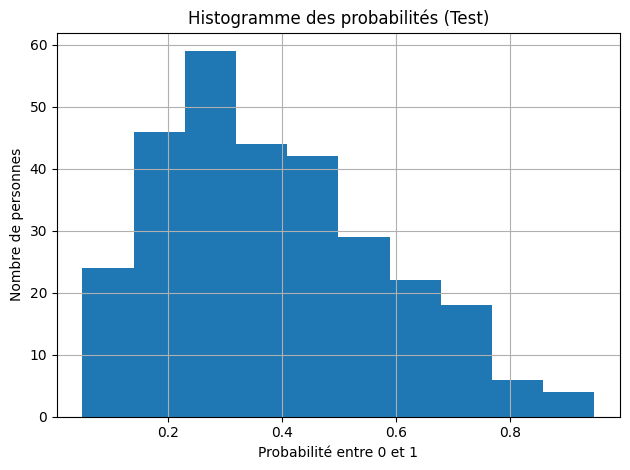

In [23]:
 # Histogramme des probabilités (Test)
plt.hist(proba_test)
plt.title("Histogramme des probabilités (Test)")
plt.xlabel("Probabilité entre 0 et 1")
plt.ylabel("Nombre de personnes")
plt.grid()
plt.tight_layout()
plt.show()

* Ce que l'on voit sur ce graphique c'est une concentration des probabilités entre 0.2 et 0.5, ce qui indique que le modèle donne des probabilités plutôt faible donc vers la classe négative, c'est à dire sur les salariés restants dans l'entreprise.
* On identifie un petit étalement à droite, donc que le modèle a quelques certitudes concernant des employés partis mais cela reste faible.
* L'histogramme représente bien notre jeu désequilibré avec des cas majoritairement dans la classe 0.
* Avec un seuil à 0.5 (celui de base), le modèle va donc classer plus de 0 que de 1.

### Ajout du calcul de l'average precision et création de la courbe PR

PR AUC (Average Precision) — TEST : 0.555


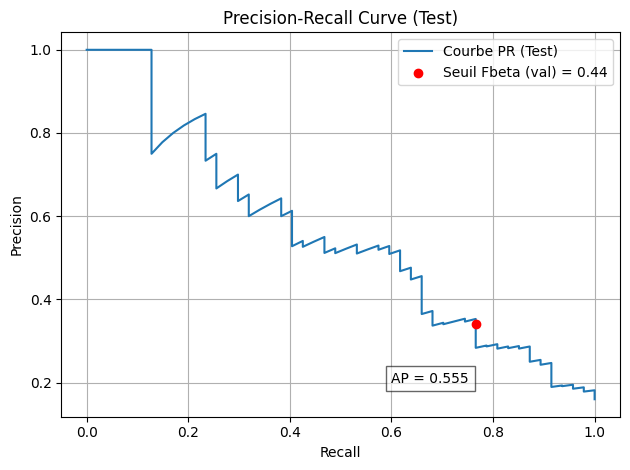

In [ ]:
ap_test = average_precision_score(y_test, proba_test)   # PR AUC (Average Precision) — Test
print(f"PR AUC (Average Precision) — TEST : {ap_test:.3f}")
# Courbe PR (Test) pour visualiser + point au seuil optimal
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test)
# Point obtenu par application du seuil sur test
y_pred_custom = (proba_test >= best_thr).astype(int)
tp = ((y_test==1) & (y_pred_custom==1)).sum()
fp = ((y_test==0) & (y_pred_custom==1)).sum()
fn = ((y_test==1) & (y_pred_custom==0)).sum()
prec_pt = tp / (tp + fp)
rec_pt  = tp / (tp + fn)
plt.plot(recall_test, precision_test, label="Courbe PR (Test)")
plt.scatter(rec_pt, prec_pt, color="red", zorder=5, label=f"Seuil Fbeta (val) = {best_thr:.2f}")
plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

* Sur ce graphique nous retrouvons notre recall en abscisse et notre precision en ordonnée. Cette courbe représente le compromis entre le rappel et la précision. Chaque point de la courbe correspond à un seuil de décision différent.
* AP=0.555, le modèle fait mieux qu’un tirage aléatoire, mais il reste beaucoup de marge.
* Le point rouge correspond au seuil trouvé sur la validation (fbeta, donc favorisant le rappel) qui est donc de 0.44, il se trouve donc un peu plus bas que le seuil de standard de 0.50. Le modèle va chercher un score de probabilité plus bas pour récupérer des vrais positifs.

### Regardons à présent la différence de notre métrique de la balanced accuracy, entre le seuil de base et le seuil optimal calculé avec fbeta

In [13]:
print("=== balanced accuracy score - TEST (0.5) ===")
print(round(balanced_accuracy_score(y_test, y_pred_test), 3))
print(f"=== balanced accuracy score - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(round(balanced_accuracy_score(y_test, y_pred_custom), 3))

=== balanced accuracy score - TEST (0.5) ===
0.733
=== balanced accuracy score - TEST (seuil F2.0 VALIDATION) ===
0.741


balanced_accuracy = est la moyenne entre la sensibilité et la spécificité, qui mesure la précision moyenne obtenue à partir des classes minoritaires et majoritaires.
On peut observer une légère augmentation de la précision moyenne en passant de 0.733 à 0.741 avec la seuil optimal.

### On peut regarder les classification report du train/test à 0.5/test avec le seuil optimal

In [15]:
print("=== Classification Report - TRAIN ===")
print(classification_report(y_train, y_pred_train, digits=3))
print("=== Classification Report - TEST (0.5) ===")
print(classification_report(y_test, y_pred_test, digits=3))
print(f"=== Classification Report — TEST (seuil F{beta:.1f} VALIDATION) ===")
print(classification_report(y_test, y_pred_custom, digits=3))

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0      0.952     0.826     0.884       986
           1      0.464     0.784     0.583       190

    accuracy                          0.819      1176
   macro avg      0.708     0.805     0.734      1176
weighted avg      0.873     0.819     0.836      1176

=== Classification Report - TEST (0.5) ===
              precision    recall  f1-score   support

           0      0.926     0.806     0.861       247
           1      0.392     0.660     0.492        47

    accuracy                          0.782       294
   macro avg      0.659     0.733     0.677       294
weighted avg      0.840     0.782     0.802       294

=== Classification Report — TEST (seuil F2.0 VALIDATION) ===
              precision    recall  f1-score   support

           0      0.941     0.717     0.814       247
           1      0.340     0.766     0.471        47

    accuracy                          0.

On peut observer une amélioration de la captation de vraies prositifs avec le seuil optimal en passant d'un recall de 0.66 à 0.77 avec le sacrifice de la précision, en passant de de 0.39 à 0.34.

### On peut analyser plus finement les résultats avec une comparaison des matrices de confusion

In [18]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST (0.5) ===")
print(cm_test)

cm_test_optimal  = confusion_matrix(y_test, y_pred_custom)
print(f"=== Matrice de confusion - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(cm_test_optimal)

=== Matrice de confusion - TEST (0.5) ===
[[199  48]
 [ 16  31]]
=== Matrice de confusion - TEST (seuil F2.0 VALIDATION) ===
[[177  70]
 [ 11  36]]


* On voit bien le nombre de classe 1 du seuil optimal > classe 1 seuil de base : 36 vs 31
* A contrario on constate beaucoup plus de faux positifs : 70 vs 48

#### Ici le choix de mettre l'accent sur le recall nous donne un modèle capable de retrouver plus de départs au détriment d'une meilleure précision. L'objectif de la mission est de réaliser un modèle de classification capable de scorer la probabilité de départ d'un salarié afin d'en déterminer les causes potentielles. Afin de mieux comprendre les démissions, il faut donc réussir à retrouver le maximum de départs ce que nous aide à faire ce seuil.